### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.io import savemat
import random

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import os

from datasets import load_coil20_dataloader, load_MNIST_last35k_dataloader, load_train_test_MNIST_dataloader, load_10x73k, load_TCGA, load_Pendigits, load_eMNIST_dataloader, load_MNIST_dataloader, load_MNIST_subset_dataloader, load_fashionMNIST_subset_dataloader
from evaluation import Evaluator

### Autoencoder

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, latent_dimension):
        super().__init__()
        negative_slope = 0.01
        
        # Encoder Model        
        self.encoder_model = nn.Sequential(
            nn.Linear(input_dimension, 500),
            nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            
            nn.Linear(500, 500),
            nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            
            nn.Linear(500, 2000),
            nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            
            nn.Linear(2000, latent_dimension),
            nn.Tanh(), # nn.Sigmoid(), # TODO delete?
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(  
            nn.Linear(latent_dimension, 2000),
            nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            
            nn.Linear(2000, 500),
            nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            
            nn.Linear(500, 500),
            nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
 
            nn.Linear(500, input_dimension),
        )

    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x
    
    def forward_np(self, x):
        x = torch.from_numpy(x).to(device)
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x.cpu().detach().numpy()
    
    def encoder(self, x, device):
        x = torch.from_numpy(x).to(device)
        x = self.encoder_model(x)
        return x.cpu().detach().numpy()

In [101]:
class CD_Autoencoder(nn.Module):
    def __init__(self, h1=32, h2=64, h3=128, latent_dimension=10):
        super().__init__()
        self.IMG_SIZE = 28
        self.negative_slope=0.1
        
        # Encoder
        self.encoder_model = nn.Sequential(
            nn.Conv2d(1, h1, kernel_size = 5, stride = 2, padding = 2),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm2d(h1),

            nn.Conv2d(h1, h2, kernel_size = 5, stride = 2, padding = 2),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm2d(h2),

            nn.Conv2d(h2, h3, kernel_size = 3, stride = 2, padding = 0),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm2d(h3),

            nn.Flatten(start_dim=1),
            nn.Linear(h3 * 3 * 3, latent_dimension, bias=True), # latent_dimension * 3 * 3
            #nn.ReLU(inplace=True),
            #nn.Sigmoid(),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm1d(latent_dimension), #TODO
        )
        
        # Decoder 
        self.decoder_model = nn.Sequential(
            nn.Linear(latent_dimension,  h3 * 3 * 3, bias=True),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm1d(h3 * 3 * 3),
            nn.Unflatten(dim = 1, unflattened_size = (h3, 3, 3)),

            nn.ConvTranspose2d(h3, h2, kernel_size = 3, stride = 2, padding = 0),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm2d(h2),
          
            nn.ConvTranspose2d(h2, h1, kernel_size = 5, stride = 2, padding = 2, output_padding = 1),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm2d(h1),
          
            nn.ConvTranspose2d(h1, 1, kernel_size = 5, stride = 2, padding = 2, output_padding = 1),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=self.negative_slope, inplace=True),
            nn.BatchNorm2d(1)
        )
        
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def encoder(self, x, device):
        x = np.reshape(x, (x.shape[0], 1, self.IMG_SIZE, self.IMG_SIZE))
        x = torch.from_numpy(x).to(device)
        x = self.encoder_model(x)
        x = x.cpu().detach().numpy()
        return x
    
    def encoder_memory(self, dataloader, device):
        list_embeddings = list()
        list_lables = list()
        
        self.eval()
        for _, (batch, labels) in enumerate(dataloader):
            batch = batch.to(device)
            batch_embeddings = self.encoder_model(batch)
            batch_embeddings = batch_embeddings.cpu().detach().numpy()
            list_embeddings.append(batch_embeddings)
            
            labels = labels.cpu().detach().numpy()
            list_lables.append(labels)
            
        return np.concatenate(list_embeddings, axis=0), np.concatenate(list_lables, axis=0)

In [5]:
def pretrain_autoencoder(device, dataloader, autoencoder, epochs=100, batch_size=256):
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
    loss_list = list()
    
    autoencoder.train()
    for epoch in range(epochs):
        loss = 0
        for batch_index, (batch, labels) in enumerate(dataloader):
            # Data to cuda device
            batch = batch.to(device)
            
            # reset the gradients to zero
            # optimizer.zero_grad()
            autoencoder.zero_grad()

            # compute reconstructions
            reconstructions = autoencoder(batch)
            
            # compute reconstruction loss
            train_loss = criterion(reconstructions, batch)

            # compute accumulated gradients
            train_loss.backward()

            # update model parameters
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        loss_list.append(loss)
        print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
        
    autoencoder.eval()
    return autoencoder, loss_list

### Visualization

In [6]:
color_list = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys())
np.random.shuffle(color_list)
color_list = ['deepskyblue', 'gold', 'hotpink', 'limegreen'] + color_list

In [7]:
def plot_tsne(tsne_embeddings, labels, path=None):
    fontsize = 15
    plt.figure(figsize=(12, 12))

    unique_labels = np.unique(labels)

    for label_id in unique_labels:
        selected_indexes = np.where(labels == label_id)[0]
        x = tsne_embeddings[selected_indexes, 0]
        y = tsne_embeddings[selected_indexes, 1]

        #color = [label_id] * selected_indexes.shape[0]
        c = [color_list[label_id]] * selected_indexes.shape[0]
        plt.scatter(x=x, y=y, c=c, edgecolors='black')

    plt.xlabel('$z_1$', fontsize=fontsize)
    plt.ylabel('$z_2$', fontsize=fontsize)

    plt.legend(unique_labels, fontsize=fontsize)
    
    if path:
        plt.savefig(path + '/t-SNE.png')
    else:
        plt.show()

### Evaluation method

In [8]:
def kmeans_evaluation(n_clusters, data, labels):
    kmeans_labels = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++').fit_predict(data)

    evaluator = Evaluator()
    evaluator.evaluate_clustering(labels, kmeans_labels)
    evaluator.print_evaluation()
    
    ACC = evaluator.get_cluster_accuracy()
    PUR = evaluator.get_purity()
    NMI = evaluator.get_nmi()
    ARI = evaluator.get_ari()

    return ACC, PUR, NMI, ARI

### Loading the data

#### 10x-73k

In [ ]:
batch_size = 256
n_clusters = 8

dataloader, data_shape, data_np, labels = load_10x73k(batch_size=batch_size)

#### TCGA

In [7]:
batch_size = 256
n_clusters = 5

dataloader, data_shape, data_np, labels = load_TCGA(batch_size=batch_size)

#### COIL-20

In [9]:
batch_size = 256
n_clusters = 20

dataloader, data_shape, data_np, labels = load_coil20_dataloader(batch_size=batch_size)

#### Mnist

In [9]:
batch_size = 256
create_subset = True
data_per_pattern = 10_000
n_clusters = 10

dataloader, data_shape, data_np, labels = load_MNIST_subset_dataloader(batch_size=batch_size, create_subset=create_subset, data_per_pattern=data_per_pattern)

KeyboardInterrupt: 

#### Mnist Train and Test 

In [10]:
batch_size = 256
create_subset = True
data_per_pattern = 10_000
n_clusters = 10

dataloader, data_shape, data_np, labels = load_train_test_MNIST_dataloader(batch_size=batch_size, create_subset=create_subset, data_per_pattern=data_per_pattern)

#### Mnist subset

In [10]:
batch_size = 256
n_clusters = 10

dataloader, data_shape, data_np, labels = load_MNIST_last35k_dataloader(batch_size=batch_size)

In [11]:
data_np.shape, labels.shape

((60000, 1, 28, 28), (60000,))

#### EMNIST 

In [20]:
batch_size = 256
n_clusters = 37

dataloader, data_shape, data_np, labels = load_eMNIST_dataloader(batch_size=batch_size, option='balanced letters')

In [9]:
batch_size = 256
n_clusters = 10

dataloader, data_shape, data_np, labels = load_eMNIST_dataloader(batch_size=batch_size, option='mnist')

In [74]:
batch_size = 256
n_clusters = 10

dataloader, data_shape, data_np, labels = load_eMNIST_dataloader(batch_size=batch_size, option='balanced digits')

In [75]:
data_np.shape, labels.shape

((28000, 1, 28, 28), (28000,))

In [76]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Fashion-Mnist

In [24]:
batch_size = 256
create_subset = True
data_per_pattern = 10_000
n_clusters = 10

dataloader, data_shape, data_np, labels = load_fashionMNIST_subset_dataloader(batch_size=batch_size, create_subset=create_subset, data_per_pattern=data_per_pattern)

#### Pendigits

In [25]:
batch_size = 256

n_clusters = 10
dataloader, data_shape, data_np, labels = load_Pendigits(batch_size=batch_size)

### $k$-means on data-space

In [10]:
kmeans_evaluation(n_clusters, data_np, labels)

ACC: 0.68 PUR: 0.71 NMI: 0.69 ARI: 0.54


(0.6786762743528156,
 0.7100346944222045,
 0.6871465625004219,
 0.5353761540574168)

### Training Procedure

#### MLP autoencoder

In [44]:
epochs = 100
latent_dimension = 5
autoencoder = Autoencoder(input_dimension=data_shape, latent_dimension=latent_dimension).to(device)
autoencoder, _ = pretrain_autoencoder(device, dataloader, autoencoder, epochs=epochs, batch_size=batch_size)
latent_data = autoencoder.encoder(data_np, device)

Epoch: 1/100, Loss: 3.027513
Epoch: 2/100, Loss: 0.901249
Epoch: 3/100, Loss: 0.471217
Epoch: 4/100, Loss: 0.306927
Epoch: 5/100, Loss: 0.225810
Epoch: 6/100, Loss: 0.187677
Epoch: 7/100, Loss: 0.161098
Epoch: 8/100, Loss: 0.142097
Epoch: 9/100, Loss: 0.127462
Epoch: 10/100, Loss: 0.119631
Epoch: 11/100, Loss: 0.117187
Epoch: 12/100, Loss: 0.107682
Epoch: 13/100, Loss: 0.102625
Epoch: 14/100, Loss: 0.096892
Epoch: 15/100, Loss: 0.096311
Epoch: 16/100, Loss: 0.091550
Epoch: 17/100, Loss: 0.089052
Epoch: 18/100, Loss: 0.086973
Epoch: 19/100, Loss: 0.086428
Epoch: 20/100, Loss: 0.082196
Epoch: 21/100, Loss: 0.079470
Epoch: 22/100, Loss: 0.079371
Epoch: 23/100, Loss: 0.076368
Epoch: 24/100, Loss: 0.076228
Epoch: 25/100, Loss: 0.075000
Epoch: 26/100, Loss: 0.073576
Epoch: 27/100, Loss: 0.072553
Epoch: 28/100, Loss: 0.068788
Epoch: 29/100, Loss: 0.068835
Epoch: 30/100, Loss: 0.071202
Epoch: 31/100, Loss: 0.066907
Epoch: 32/100, Loss: 0.065777
Epoch: 33/100, Loss: 0.064514
Epoch: 34/100, Loss

In [21]:
latent_data = autoencoder.encoder(data_np.astype(np.float32), device)

#### Conv-DeConv Autoencoder

In [102]:
epochs = 100
latent_dimension = 10

autoencoder = CD_Autoencoder(latent_dimension=latent_dimension).to(device)
autoencoder, _ = pretrain_autoencoder(device, dataloader, autoencoder, epochs=epochs, batch_size=batch_size)
# latent_data = autoencoder.encoder(data_np, device)
latent_data, labels = autoencoder.encoder_memory(dataloader, device)

Epoch: 1/100, Loss: 58.078349
Epoch: 2/100, Loss: 36.856793
Epoch: 3/100, Loss: 25.536383
Epoch: 4/100, Loss: 17.530456
Epoch: 5/100, Loss: 11.903500
Epoch: 6/100, Loss: 7.986710
Epoch: 7/100, Loss: 5.394381
Epoch: 8/100, Loss: 3.751650
Epoch: 9/100, Loss: 2.768880
Epoch: 10/100, Loss: 2.183591
Epoch: 11/100, Loss: 1.864456
Epoch: 12/100, Loss: 1.712026
Epoch: 13/100, Loss: 1.606993
Epoch: 14/100, Loss: 1.554818
Epoch: 15/100, Loss: 1.528009
Epoch: 16/100, Loss: 1.511023
Epoch: 17/100, Loss: 1.503592
Epoch: 18/100, Loss: 1.487360
Epoch: 19/100, Loss: 1.477764
Epoch: 20/100, Loss: 1.458304
Epoch: 21/100, Loss: 1.452127
Epoch: 22/100, Loss: 1.430086
Epoch: 23/100, Loss: 1.429356
Epoch: 24/100, Loss: 1.424493
Epoch: 25/100, Loss: 1.403680
Epoch: 26/100, Loss: 1.416614
Epoch: 27/100, Loss: 1.381844
Epoch: 28/100, Loss: 1.376705
Epoch: 29/100, Loss: 1.376200
Epoch: 30/100, Loss: 1.361582
Epoch: 31/100, Loss: 1.349597
Epoch: 32/100, Loss: 1.346323
Epoch: 33/100, Loss: 1.353610
Epoch: 34/100,

### Evaluation to embedded space after training

In [107]:
kmeans_evaluation(n_clusters, MinMaxScaler().fit_transform(latent_data), labels.astype(np.int32))

ACC: 0.79 PUR: 0.79 NMI: 0.72 ARI: 0.64


(0.7859642857142857, 0.7859642857142857, 0.7162264392147024, 0.641175306554402)

In [108]:
kmeans_evaluation(n_clusters, latent_data, labels.astype(np.int32))

ACC: 0.67 PUR: 0.71 NMI: 0.67 ARI: 0.55


(0.6654642857142857,
 0.7069642857142857,
 0.6728808180591657,
 0.5487638462920972)

In [105]:
'''
for batch_index, (batch, labels) in enumerate(dataloader):
    # Data to cuda device
    batch = batch.to(device)
    rec = autoencoder(batch)

for i in range(batch_size):
    plt.imshow(np.reshape(rec.cpu().detach().numpy()[i], (28, 28)), cmap='gray')
    plt.show()
'''

"\nfor batch_index, (batch, labels) in enumerate(dataloader):\n    # Data to cuda device\n    batch = batch.to(device)\n    rec = autoencoder(batch)\n\nfor i in range(batch_size):\n    plt.imshow(np.reshape(rec.cpu().detach().numpy()[i], (28, 28)), cmap='gray')\n    plt.show()\n"

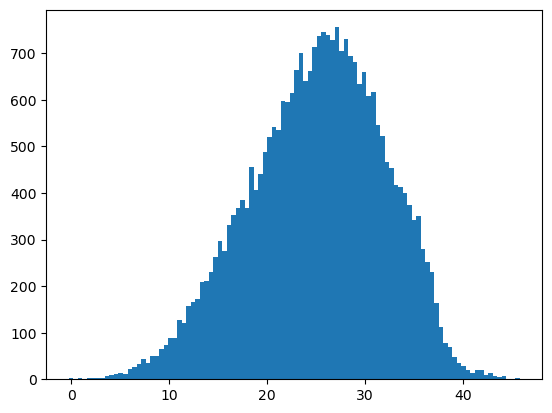

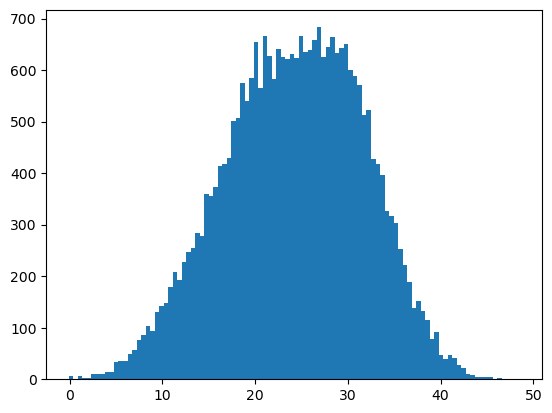

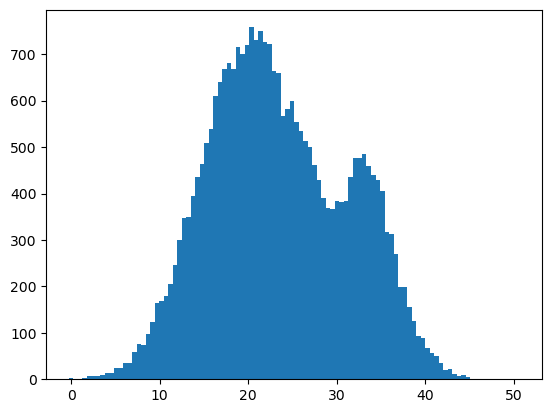

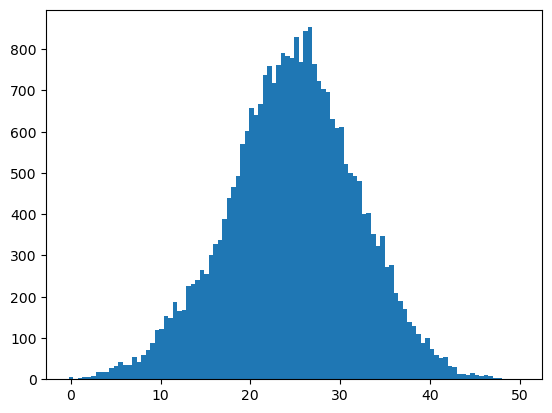

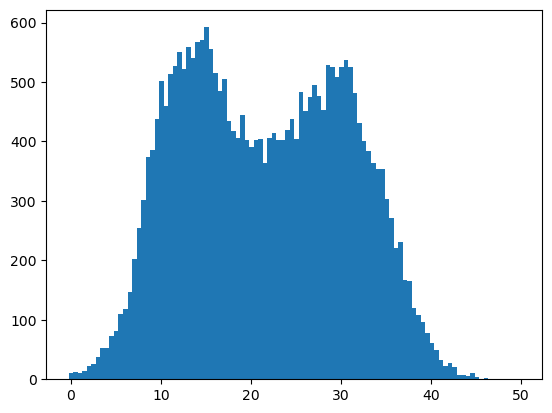

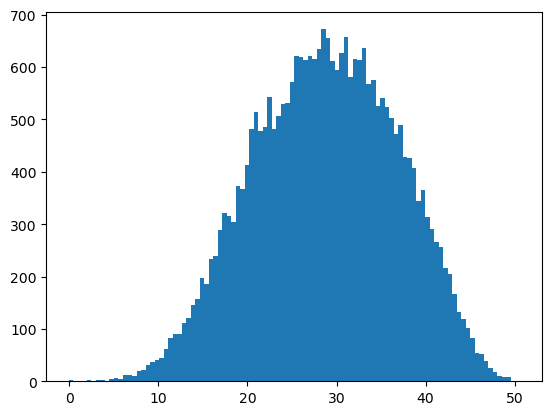

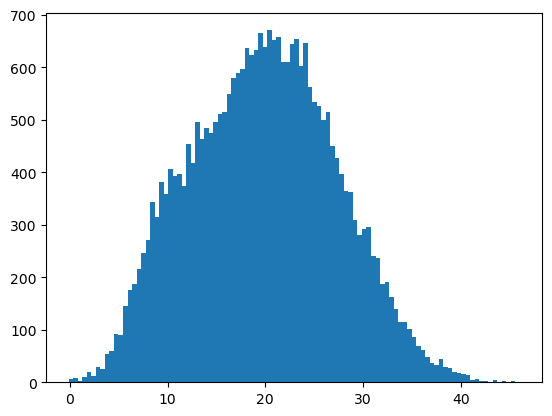

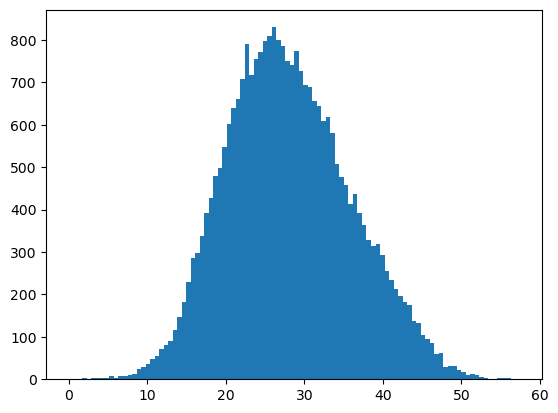

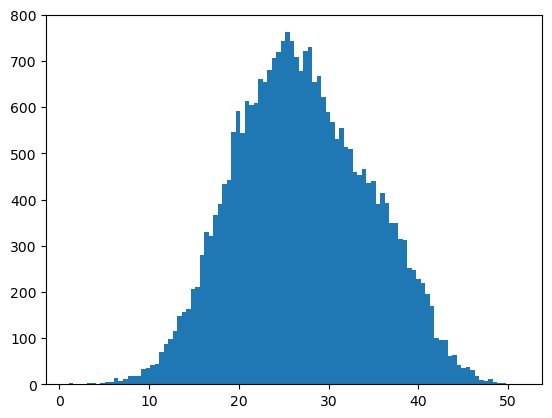

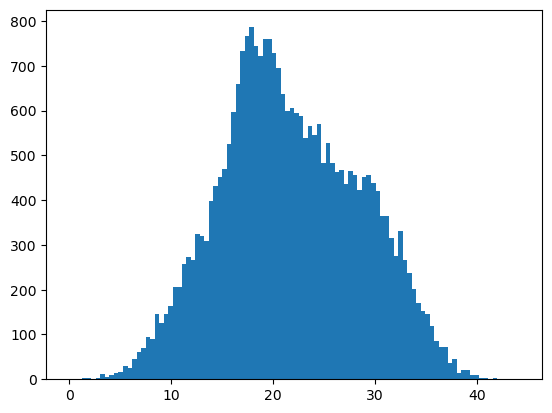

In [110]:
for i in range(latent_dimension):
    plt.hist(latent_data[:,i], bins=100)
    #plt.scatter(latent_data[:,i], latent_data[:,i], c=labels)
    plt.show()

TypeError: Invalid shape (7494,) for image data

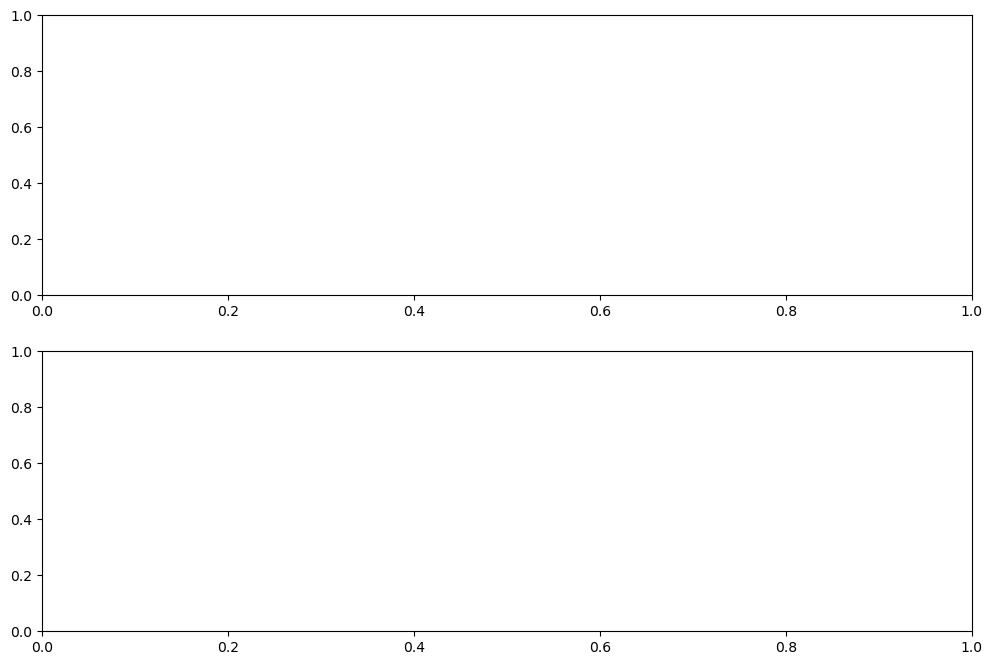

In [73]:
gridsize = (2, 1)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))

#sctr = ax1.scatter(x=latent_data[:,i], y=latent_data[:,i], c=labels, cmap='RdYlGn')
#ax1.colorbar(sctr, format='$%d')
#extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]

ax1.imshow(latent_data[:,0], cmap="plasma", aspect="auto")#, extent=extent)
ax1.set_yticks([])
ax1.set_xlim(extent[0], extent[1])

#ax1.set_yscale('log')
ax2.hist(latent_data[:,i], bins='auto')

plt.show()

In [63]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.5.2


### Save embedded data

In [26]:
dataset_name = 'COIL20_LeakyReLy'

np.save('./' + dataset_name + '.npy', latent_data) 
np.save('./' + dataset_name + '_labels.npy', labels)
savemat('./' + dataset_name + '.mat', {'X':latent_data, 'C':labels+1})

### TSNE in embedded space

In [24]:
tsne = TSNE(n_components=2, perplexity=5)
tsne_embeddings = tsne.fit_transform(latent_data)

/home/geo/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/geo/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


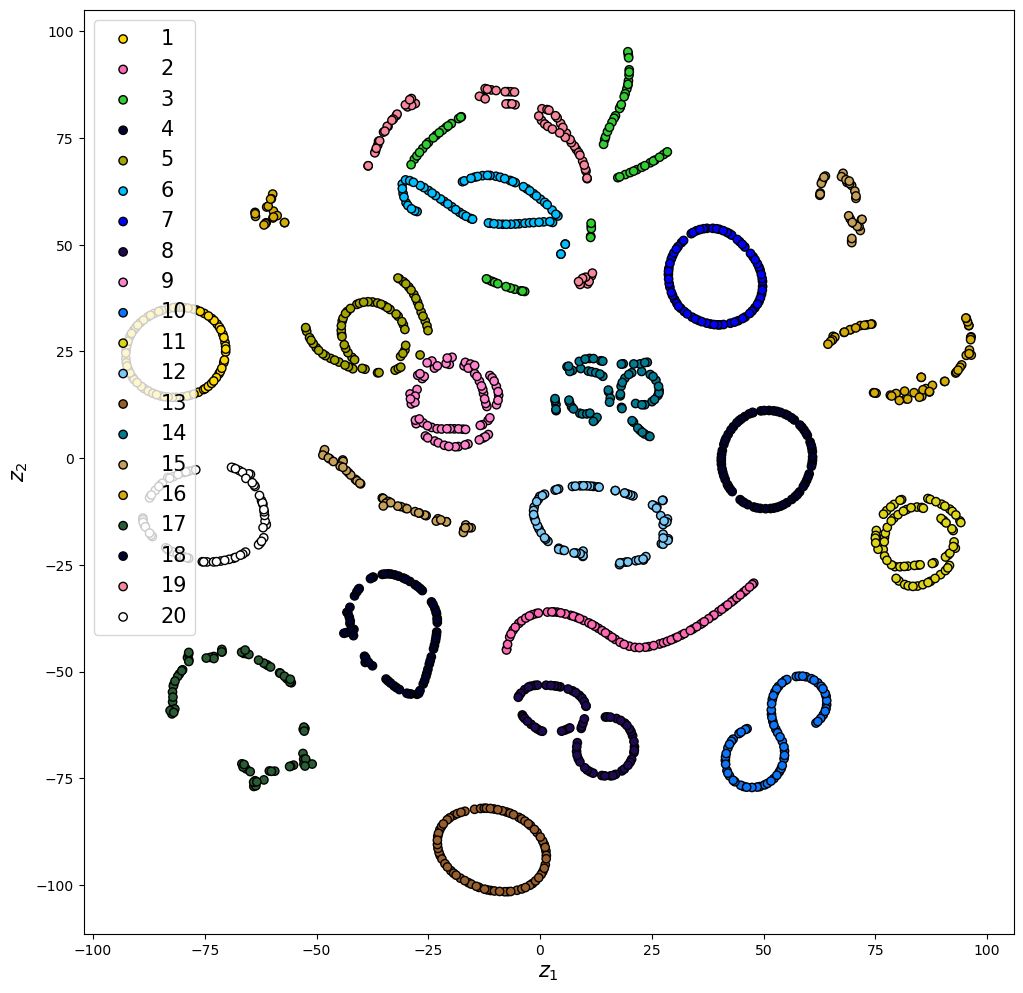

In [25]:
plot_tsne(tsne_embeddings, labels.astype(np.int32))

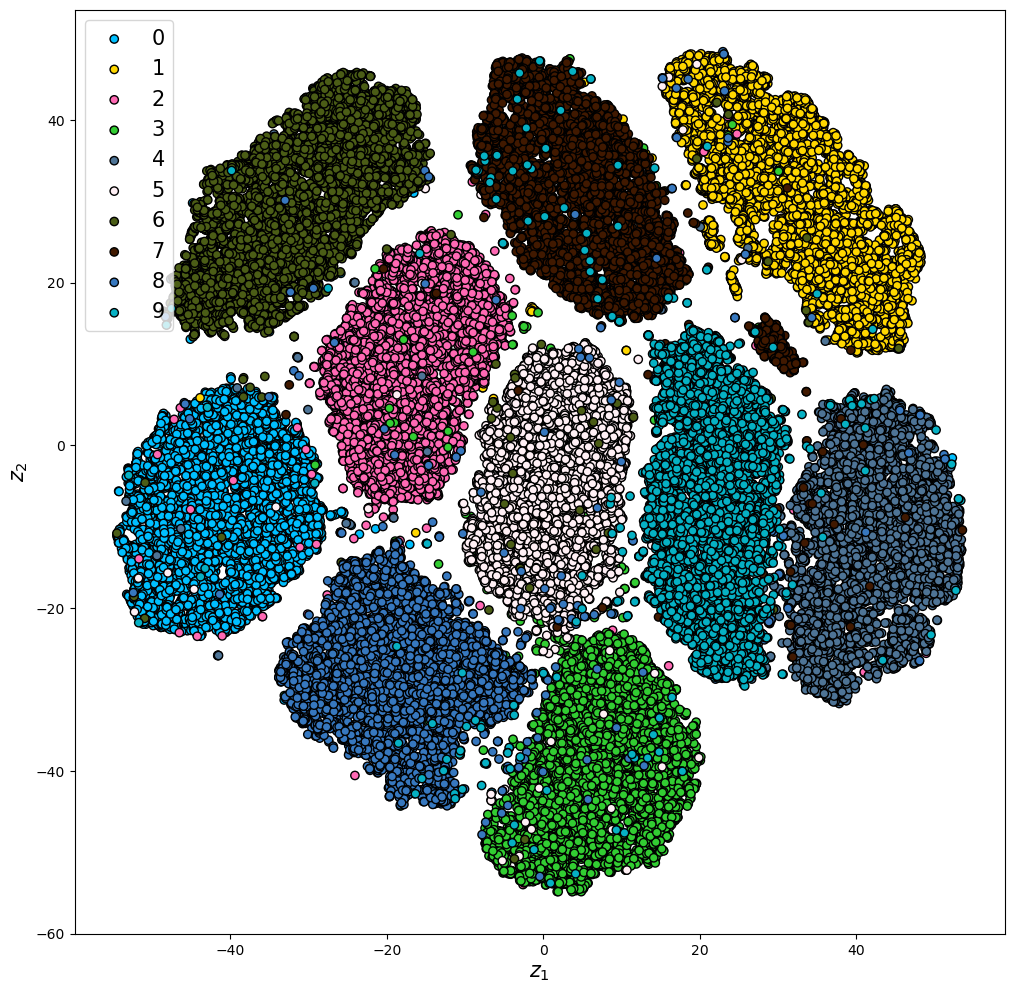

In [22]:
plot_tsne(tsne_embeddings, labels.astype(np.int32))